# Situation: 
Driven by the need to ensure that students are highly employable, university J runs a placement scheme for their post grad MBA students. After running the scheme for some time, they have secured data on over 200 students who applied to the scheme. 

They now, however, wishes to ensure that the system is optimised and works for all eligible students . As such, they have asked for insight on: 
* whether the scheme discriminate/ favour certain students?
* Students success rate depending on their academic performance.
* A mechanism for predicting if a student is likely to successfully placed. 

Based upon the staff member's input the client has asked for two to three models, comprising of SVC, logistic regression and a random forest. 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os

# libraries for visualisation
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("/kaggle/input/factors-affecting-campus-placement/Placement_Data_Full_Class.csv")

# Overview
The data provide by the university is anonymised and consists of the following information for over 200 students. 

| Column name | Column detail  | Data type |
| --- | --- | --|
|gender | Male='M', Female='F' | Categorical, binary |
|ssc_p | Secondary Education percentage- 10th Grade | Numerical, continuous | 
|ssc_b  | Board of Education- Central/ Others | Categorical, normal  |
|hsc_p|Higher Secondary Education percentage- 12th Grade| Numerical, continuous |
|hsc_b|Board of Education- Central/ Others| Categorical, normal |
|hsc_s|Specialization in Higher Secondary Education|Categorical, normal | 
|degree_p|Degree Percentage| Numerical continuous | 
| degree_t| Under Graduation(Degree type)- Field of degree education| Categorical, normal|
|workex|Work Experience|Categorical, binary |
|etest_p|Employability test percentage ( conducted by college)|Numerical, continuous |
|specialisation|Post Graduation(MBA)- Specialization|Categorical, normal |
|mba_p|MBA percentage|Numerical, continuous |
|status|Status of placement- Placed/Not placed|Categorical, binary |
|Salary|Salary offered by corporate to candidates|Numerical, discreate|

In [2]:
df.head()

,sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
0,1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000.0
1,2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000.0
2,3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000.0
3,4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NaN
4,5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           215 non-null    int64  
 1   gender          215 non-null    object 
 2   ssc_p           215 non-null    float64
 3   ssc_b           215 non-null    object 
 4   hsc_p           215 non-null    float64
 5   hsc_b           215 non-null    object 
 6   hsc_s           215 non-null    object 
 7   degree_p        215 non-null    float64
 8   degree_t        215 non-null    object 
 9   workex          215 non-null    object 
 10  etest_p         215 non-null    float64
 11  specialisation  215 non-null    object 
 12  mba_p           215 non-null    float64
 13  status          215 non-null    object 
 14  salary          148 non-null    float64
dtypes: float64(6), int64(1), object(8)
memory usage: 25.3+ KB


The scheme in general has been successful with nearly 70% of students finding a placement via the scheme. 

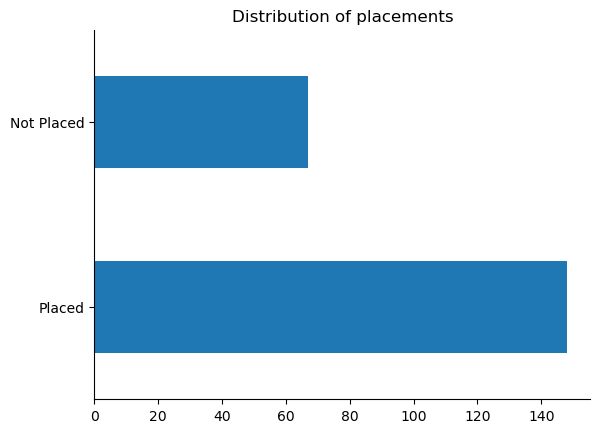

In [4]:
df["status"].value_counts().plot(kind = "barh")
sns.despine(top = True, right = True, left = False, bottom = False)
plt.title("Distribution of placements")

plt.show()

In [5]:
percent = round((df[df["status"]=="Placed"].shape[0]/df.shape[0])*100,2)

print (f"{percent}% of the data includes non cancelled.")

68.84% of the data includes non cancelled.


In [6]:
x = df.drop(["status","salary"], axis=1)
y = df["status"]


from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =.3, random_state = 360)

train = x_train.join(y_train).copy()
test = x_test.join(y_test).copy()



train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 126 to 64
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sl_no           150 non-null    int64  
 1   gender          150 non-null    object 
 2   ssc_p           150 non-null    float64
 3   ssc_b           150 non-null    object 
 4   hsc_p           150 non-null    float64
 5   hsc_b           150 non-null    object 
 6   hsc_s           150 non-null    object 
 7   degree_p        150 non-null    float64
 8   degree_t        150 non-null    object 
 9   workex          150 non-null    object 
 10  etest_p         150 non-null    float64
 11  specialisation  150 non-null    object 
 12  mba_p           150 non-null    float64
 13  status          150 non-null    object 
dtypes: float64(5), int64(1), object(8)
memory usage: 21.6+ KB


# Gender & Placement

The first request by the university is to gain understanding on the performance of the different genders in the scheme. 

In [7]:
from pandas.api.types import is_string_dtype

        
def pivot_satisfaction (train, variable): 
    
    #All = data.shape[0]
    
    df_pivot = train.pivot_table(index= variable, columns="status", values="sl_no", aggfunc="count")
    
    df_pivot["total"] = df_pivot["Not Placed"]+df_pivot["Placed"]
    df_pivot["Placement_rate (%)"] = df_pivot["Placed"]/df_pivot["total"]*100
    
    df_pivot = df_pivot.style.background_gradient(axis=0, subset=['Placement_rate (%)'])
    
    return df_pivot       
        
def graph (data, variable, title):
    plt.figure(figsize = (10,4))
    if is_string_dtype(data[variable]) ==True:
        sns.countplot(data = data, y = variable, hue ="status", palette = "pastel" )
        sns.despine(top = True, right = True, left = False, bottom = False)
        plt.title(f"Popularity of {title}")
    else:
        sns.histplot(data= data, x = variable, hue ="status" ,palette = "bright")
        sns.despine(top = True, right = True, left = False, bottom = False)
        plt.title(f"Distribution of {title}")
        
        
pivot_satisfaction (train, "gender")

status,Not Placed,Placed,total,Placement_rate (%)
gender,,,,
F,21,29,50,58.000000
M,28,72,100,72.000000


Sadly, there appears to be a gender imbalance between female and male students. Males dominate the scheme with double the numbers compared to their female classmates. Their success rate also higher with 72% of male students securing a place compared to 58% of female students. Subsequently, it is recommended that the university targets more females to join the scheme.

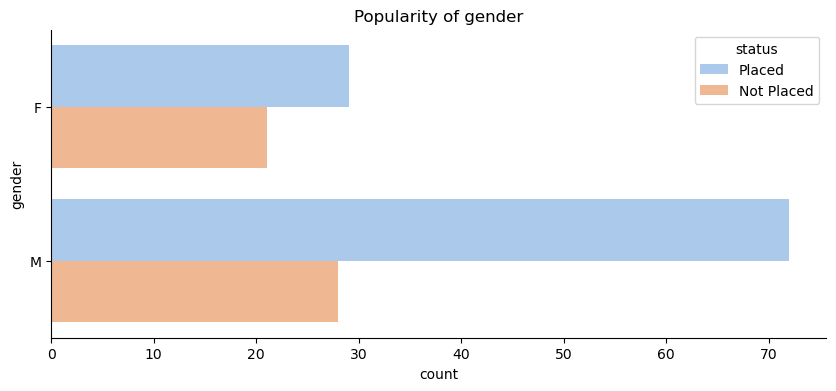

In [8]:
graph (train, "gender", "gender")

# Placement & Other factors 

For the remaining key markers, the following insights can be drawn. 

## Secondary Education percentage- 10th Grade / Higher Secondary Education percentage- 12th Grade

Those who scored lower on their 10th grade examination appears to have difficulty finding a placement. However, this is not an absolute statement. There are some individuals with scores between 45 and 60% that were also able to secure a placement. 

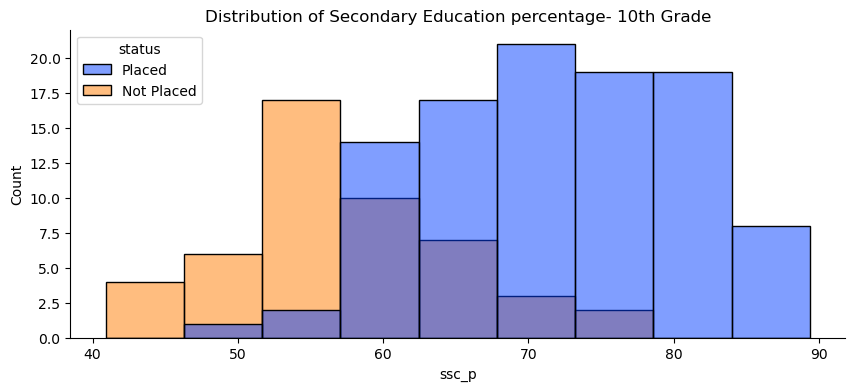

In [9]:
graph (train, "ssc_p", "Secondary Education percentage- 10th Grade")

That said, if the success of a student is determined at grade 10, the merit of further education for the program is limited. This can be discouraging for those students who scored lower and can also lead to students inferring that their options are already limited by the grade 10 examination. 

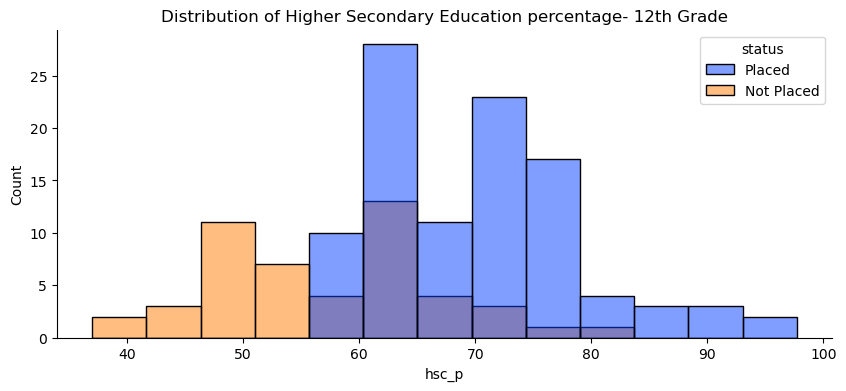

In [10]:
graph (train, "hsc_p", "​Higher Secondary Education percentage- 12th Grade")

The impact of this worsens with the examination at grade 12. Once again, if the successful placement is determined by factors prior to university, the role of the university is undermined/limited. 

## Board of Education- Central/ Others 
The impact of the examination boards is limited. The variables are somewhat uneven as it is split into central and other but the succuss rate varies only by 6-8%.This ratio remains relatively stable for both 10th and 12th grade examinations. 

In [11]:
pivot_satisfaction (train, "ssc_b",)

status,Not Placed,Placed,total,Placement_rate (%)
ssc_b,,,,
Central,29,53,82,64.634146
Others,20,48,68,70.588235


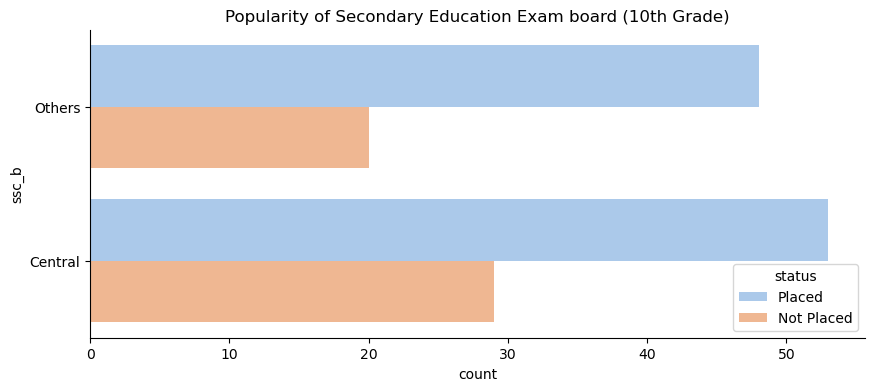

In [12]:
graph (train, "ssc_b",  "Secondary Education Exam board (10th Grade)")

In [13]:
pivot_satisfaction (train, "hsc_b")

status,Not Placed,Placed,total,Placement_rate (%)
hsc_b,,,,
Central,23,39,62,62.903226
Others,26,62,88,70.454545


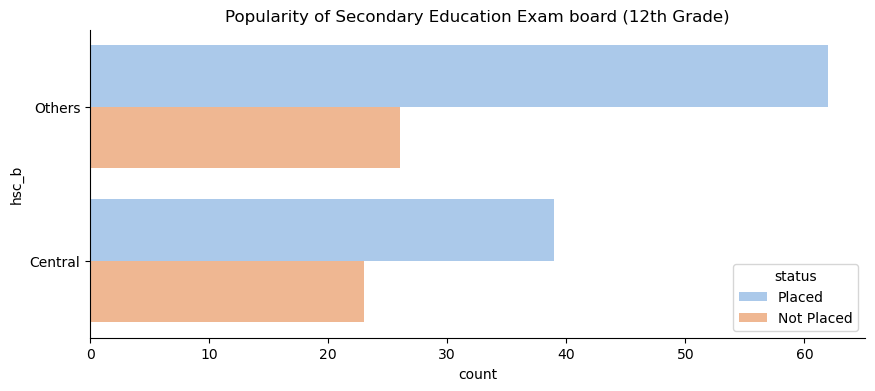

In [14]:
graph (train, "hsc_b", "Secondary Education Exam board (12th Grade)")

## Specialization in Higher Secondary Education

Students in this program have specialised in three subject area: science, commerce and arts. For science and commerce, the rate of success was higher than those who struggled to do so at approx. 60%. 


In [15]:
pivot_satisfaction (train, "hsc_s")

status,Not Placed,Placed,total,Placement_rate (%)
hsc_s,,,,
Arts,4,2,6,33.333333
Commerce,25,54,79,68.354430
Science,20,45,65,69.230769


However, for those who specialised in art, only 33% of applicants were successful. In addition, the number of such students were significantly low. Therefore, it is advised that the university make effort to provide additional support to such students engaged in this scheme. 

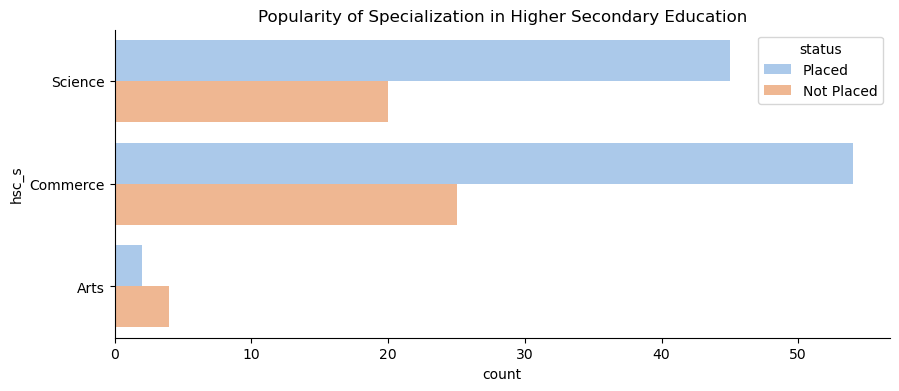

In [16]:
graph (train, "hsc_s", "Specialization in Higher Secondary Education")

## Degree Percentage
As with high school achievements, those with higher the score are more likely students were to scare a placement. That said,  the significance of this emphasises the positive results of working hard at university. 

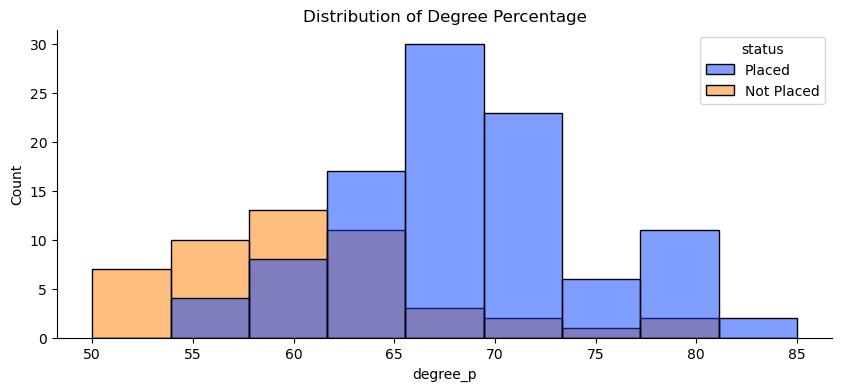

In [17]:
graph (train, "degree_p", "Degree Percentage")

## Under Graduation(Degree type)- Field of degree education

In [18]:
pivot_satisfaction (train, "degree_t")

status,Not Placed,Placed,total,Placement_rate (%)
degree_t,,,,
Comm&Mgmt,28,68,96,70.833333
Others,6,4,10,40.000000
Sci&Tech,15,29,44,65.909091


Degree type mirrors the findings of higher secondary specialisation. Students specialising in Sci&Tech, and Comm&Mgmt dominated the scheme and are more likely to secure a placement. Those classed in others, however, appear to find limited gain from the scheme. Students in such subjects were less likely to apply to the scheme and even less likely to secure a placement. Therefore, akin to the actions outlined for higher secondary specialisation, additional support is needed for those studying other subjects to enable them to excel in the placement scheme. 

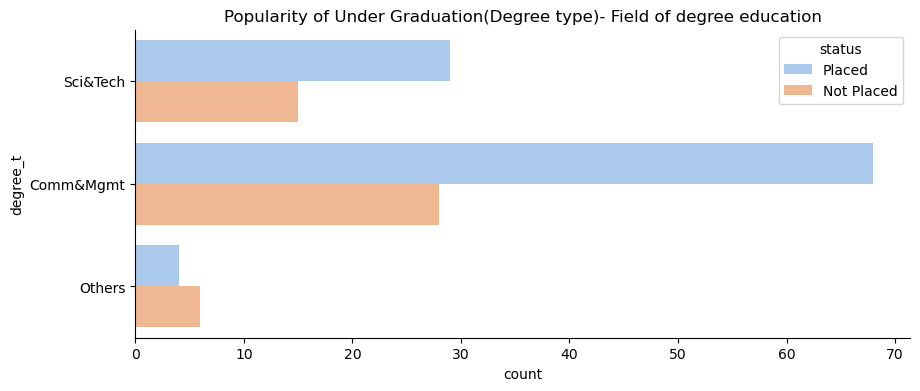

In [19]:
graph (train, "degree_t", "Under Graduation(Degree type)- Field of degree education")

## Work Experience

In [20]:
pivot_satisfaction (train, "workex")

status,Not Placed,Placed,total,Placement_rate (%)
workex,,,,
No,42,53,95,55.789474
Yes,7,48,55,87.272727


As one may suspect, students with past work experience were more likely to secure a placement. That said, students with limited work experience also had a high rate of succuss. 

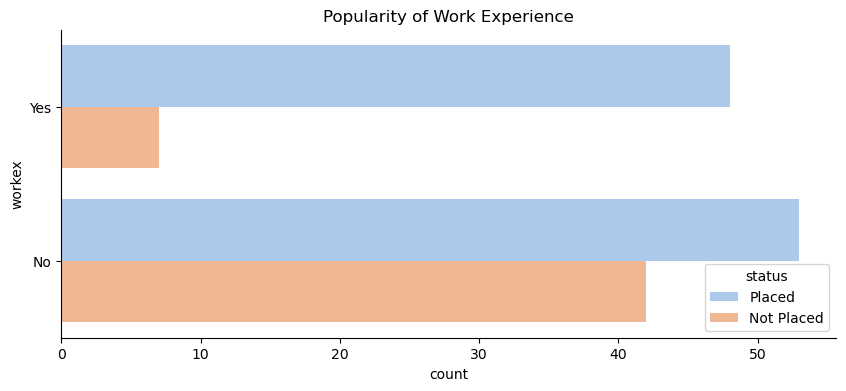

In [21]:
graph (train, "workex", "​Work Experience")

## Employability test percentage ( conducted by college) /MBA percentage 
Unlike other markers previously reviewed, it appears that employability test percentage had limited impact on students ability to secure a placement. Students with a range of scores were able to secure a placement including those who had a 50-55%. 

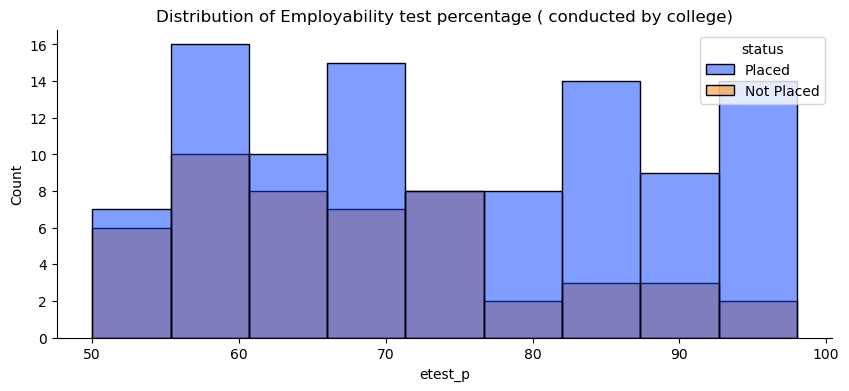

In [22]:
graph (train, "etest_p", "​Employability test percentage ( conducted by college)")

A similar finding can be seen in the MBA percentage. The impact of the percentage on securing a placement is limited. On the other hand, those who scored between 50 and 55% did struggle to secure a place.

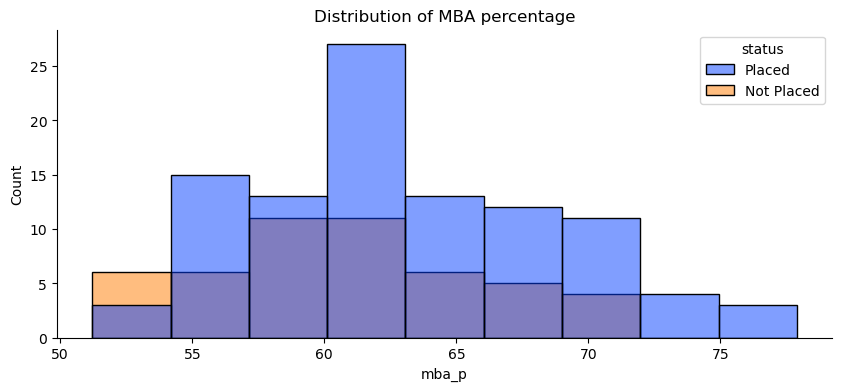

In [23]:
graph (train, "mba_p", "MBA percentage")

## Post Graduation(MBA)- Specialization

In [24]:
pivot_satisfaction (train, "specialisation")

status,Not Placed,Placed,total,Placement_rate (%)
specialisation,,,,
Mkt&Fin,19,64,83,77.108434
Mkt&HR,30,37,67,55.223881


It appears that this placement scheme covers primarily those who have/are undertaking post graduation studies in MBA and specialises in two subject areas, Mkt&Fin and Mkt&HR. Both groups of students found succuss in the program. However, the margins are greater amongst those undertaking finance. This may be due to market demand but for students undertaking the HR course may find the experience frustrating and if it were to continue, reflect poorly on the university's ability to ensure that the students were employable. 

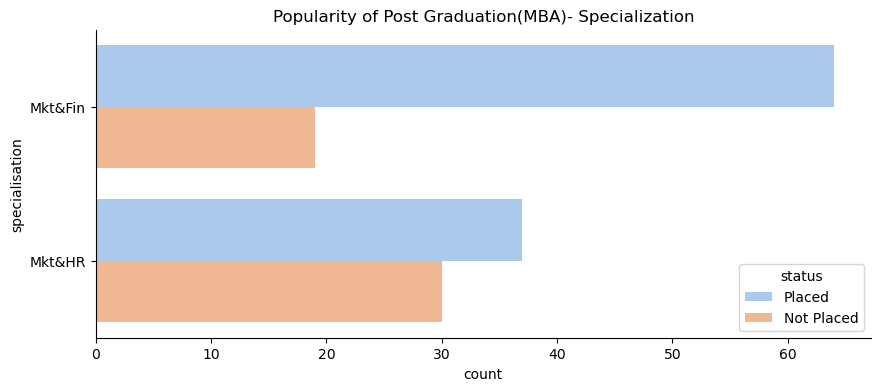

In [25]:
graph (train, "specialisation", "Post Graduation(MBA)- Specialization")

# Relationship between the variables 
Prior to the creation of a system of estimating whether a student is likely secure a placement, the following highlights the relationship between the variables. In this graph, the darker the colours the weaker the relationship is. In this case, variables such as gender and ​employability test percentage ( conducted by college) may have a weak impact on whether a student is able to secure a successful placement. Subsequently these may be dropped to ensure that the system is simple and does not overfit on existing data. 

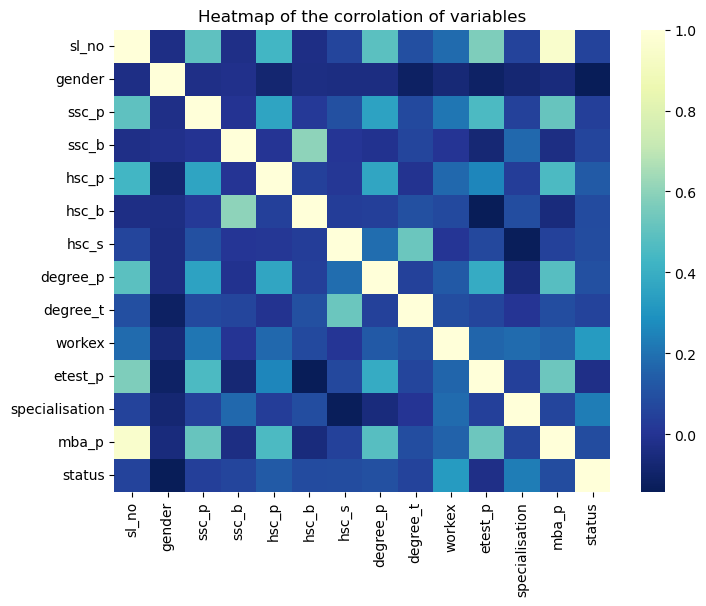

In [26]:
from scipy.stats import chisquare

df=train.apply(lambda x : pd.factorize(x)[0])+1

plt.figure(figsize = (8,6))

sns.heatmap(df.corr(),cmap="YlGnBu_r")
plt.title("Heatmap of the corrolation of variables")
plt.show()

# System for placement 
As per the request of the university, in order to access the succuss of placement, three models,  SVC, logistic regression and a random forest are to be created. Following a transformation each of the models reveal the following results: 


In [27]:
num_attributes = ["ssc_p","hsc_p" ,"degree_p","mba_p"]
cat_attributes =["ssc_b","hsc_b","hsc_s","degree_t","workex","specialisation"]


# import libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.linear_model import SGDClassifier

t= ColumnTransformer(transformers=[
    ("onehot", OneHotEncoder(),cat_attributes),
    ("scale", StandardScaler(), num_attributes)])


# transform variables 
Train_features  = t.fit_transform(x_train)
test_features = t.fit_transform(x_test)



In [28]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(Train_features, y_train)

cross_val_score(sgd_clf, Train_features, y_train, cv=5, scoring = "accuracy")
predictions = cross_val_predict(sgd_clf,test_features, y_test, cv=5,  )

print("SGDClassifier Model\n")
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

SGDClassifier Model

[[13  5]
 [ 6 41]]
              precision    recall  f1-score   support

  Not Placed       0.68      0.72      0.70        18
      Placed       0.89      0.87      0.88        47

    accuracy                           0.83        65
   macro avg       0.79      0.80      0.79        65
weighted avg       0.83      0.83      0.83        65



In [29]:
logmodel = LogisticRegression()
logmodel.fit(Train_features, y_train)

cross_val_score(logmodel, test_features, y_test, cv=5, scoring = "accuracy")
predictions = cross_val_predict(logmodel,test_features, y_test, cv=5,  )

print("Logistic Regression Model\n")
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

Logistic Regression Model

[[13  5]
 [ 2 45]]
              precision    recall  f1-score   support

  Not Placed       0.87      0.72      0.79        18
      Placed       0.90      0.96      0.93        47

    accuracy                           0.89        65
   macro avg       0.88      0.84      0.86        65
weighted avg       0.89      0.89      0.89        65



In [30]:
from sklearn.ensemble import RandomForestClassifier


forest_clf = RandomForestClassifier(random_state=42)

predictions = cross_val_predict(forest_clf,test_features, y_test, cv=5,  )

print("Random Forest Classifier Model\n")
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

Random Forest Classifier Model

[[ 7 11]
 [ 1 46]]
              precision    recall  f1-score   support

  Not Placed       0.88      0.39      0.54        18
      Placed       0.81      0.98      0.88        47

    accuracy                           0.82        65
   macro avg       0.84      0.68      0.71        65
weighted avg       0.83      0.82      0.79        65



Given the purpose of the system, the logistic regression may be the best as not only does it have a high F1 score for placed students but is also good at identifying those who are less likely to secure a placement. In other words, the model would also enable the university to provide additional support to such students. 

As the scheme continues, it is likely that the models can be altered to further accurately predict the students. Further complex models may also be trialled.  
 
# Conclusion
There are some concerning patterns found in the success rates of the students. It is recommended that university invests in aiding under represented groups such as female students and those who have studied subjects such as art other subjects. 

It is hoped that through the use of the logistic model, the university could identify students that are at risk and provide additional support.

The university is likely to need some further assistance in relation to the model as increased data along with changes to the scheme is likely to impact the system and alterations will enable better predictions. 

Author's note: 
The data used in this project can be accessed from "[Campus Recruitment](https://www.kaggle.com/datasets/benroshan/factors-affecting-campus-placement)"